In [202]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.33.0

numpy     : 1.21.6
scipy     : 1.7.3
sklearn   : 1.0.2
pandas    : 1.3.4
matplotlib: 3.5.2



In [218]:
import numpy as np
import os
import seaborn as sns
import sklearn

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# DATA 불러오기

In [219]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment',  None)

PROJECT_ROOT_DIR = './..'
DATA_DIR = 'data'
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, DATA_DIR, )

def load_user_data(data_path = DATA_PATH):
    train_csv_path = os.path.join(data_path, 'train.csv')
    test_csv_path = os.path.join(data_path, 'test.csv')
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train, test = load_user_data(DATA_PATH)

# DATA 확인

In [220]:
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [221]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

# 테스트 데이터, 검증 데이터 분리

In [222]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy()
train_data, val_data = train_test_split(data, test_size=0.3)
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)

In [223]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (775, 22)
검증할 val 셋 :  (333, 22)


In [224]:
train_X = train_data.drop(['target', 'index'], axis = 1)
train_y = train_data.target

val_X = val_data.drop(['target', 'index'], axis = 1)
val_y = val_data.target

# 파이프라인 작성

In [225]:
from sklearn.base import BaseEstimator, TransformerMixin

class DtCustomerSplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        year, month, day = list(), list(), list()
        for date in X.Dt_Customer:
            da, mo, ye = date.split('-')
            year.append(int(ye))
            month.append(int(mo))
            day.append(int(da))
        X['year']  = year
        X['month'] = month
        X['day']   = day
        return X.drop('Dt_Customer', axis=1)

In [227]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

num_attribs = list(train_X.drop(['Marital_Status', 'Education'], axis=1))
scaler_attribs = ['Year_Birth', 'Income', 'NumWebPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
ms_cat = [['Married','Together','Single', 'Divorced','Widow','Alone','YOLO','Absurd']]
edu_cat = [['PhD','Master','Graduation','2n Cycle','Basic']]

my_pipeline = ColumnTransformer([
    ('DtCustomerSplitter', DtCustomerSplitter(), ['Dt_Customer']),
    ('OneHotEncoder', OrdinalEncoder(categories=ms_cat), ['Marital_Status']),
    ('OrdinalEncoder', OrdinalEncoder(categories=edu_cat), ['Education']),
    ('RobustScaler', RobustScaler(), scaler_attribs)
])

train_X_prepared = my_pipeline.fit_transform(train_X)
val_X_prepared = my_pipeline.fit_transform(val_X)
train_X_prepared

array([[ 2.01200000e+03,  1.20000000e+01,  2.20000000e+01, ...,
         1.14285714e+00, -2.00000000e-01, -1.00000000e+00],
       [ 2.01300000e+03,  5.00000000e+00,  3.00000000e+00, ...,
         1.14285714e+00,  8.00000000e-01, -1.66666667e+00],
       [ 2.01400000e+03,  6.00000000e+00,  2.00000000e+01, ...,
        -5.71428571e-01, -2.00000000e-01, -3.33333333e-01],
       ...,
       [ 2.01400000e+03,  1.00000000e+00,  5.00000000e+00, ...,
        -5.71428571e-01, -2.00000000e-01,  6.66666667e-01],
       [ 2.01200000e+03,  1.20000000e+01,  6.00000000e+00, ...,
        -2.85714286e-01, -2.00000000e-01,  6.66666667e-01],
       [ 2.01300000e+03,  1.00000000e+00,  2.50000000e+01, ...,
         8.57142857e-01,  1.00000000e+00,  6.66666667e-01]])

점수 채점용 함수

In [66]:
def nmae(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

# 모델 선정

Gradient Boosting Regressor

In [174]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


gb_reg = GradientBoostingRegressor()
gb_parameters = {
    'learning_rate': [0.01, 0.02],
    'subsample': [0.6, 0.5, 0.4],
    'n_estimators': [290, 295, 300],
    'max_depth': [8, 9, 10]
}
gb_gsearch = GridSearchCV(gb_reg, param_grid=gb_parameters, cv=2, n_jobs=1)

gb_gsearch.fit(train_X_prepared, train_y)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.02], 'max_depth': [8, 9, 10],
                         'n_estimators': [290, 295, 300],
                         'subsample': [0.6, 0.5, 0.4]})

In [176]:
gb_leg_pred = gb_gsearch.predict(val_X_prepared)

XGBoost

In [183]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state = 42)

xgb_param_grid = {'n_estimators':np.arange(100,500,100),
              'max_depth':[3,4,5],
             }

xgb_rkfold = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
xgb_gsearch = GridSearchCV(xgb, xgb_param_grid, cv = xgb_rkfold, scoring='neg_mean_absolute_error',
                               verbose=1, return_train_score=True)

In [185]:
xgb_gsearch.fit(train_X_prepared, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsa

In [187]:
xgb = xgb_gsearch.best_estimator_
xgb_grid_results = pd.DataFrame(xgb_gsearch.cv_results_)
xgb_pred = xgb.predict(val_X_prepared)

print("train nmae of xgb :", nmae(val_y.values, xgb_pred))

train nmae of xgb : 0.18643626017141238


LightGBM

In [188]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(objective='regression', random_state = 42)

lgbm_param_grid = {'n_estimators': [8,16,24], 'num_leaves': [6,8,12,16], 'reg_alpha' : [1,1.2], 'reg_lambda' : [1,1.2,1.4]}


lgbm_rkfold = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
lgbm_gsearch = GridSearchCV(lgbm, lgbm_param_grid, cv = lgbm_rkfold, scoring='neg_mean_absolute_error',
                               verbose=1, return_train_score=True)

In [189]:
lgbm_gsearch.fit(train_X_prepared, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             param_grid={'n_estimators': [8, 16, 24],
                         'num_leaves': [6, 8, 12, 16], 'reg_alpha': [1, 1.2],
                         'reg_lambda': [1, 1.2, 1.4]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [190]:
lgbm = lgbm_gsearch.best_estimator_
lgbm_grid_results = pd.DataFrame(lgbm_gsearch.cv_results_)
lgbm_pred = lgbm.predict(val_X_prepared)

train nmae of lgbm : 0.2377289306684952


RandomForestRegressor

In [97]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [33, 35, 34], 'max_features': [7, 8, 9, 10, 11]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)
grid_search.fit(train_X_prepared, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [7, 8, 9, 10, 11],
                          'n_estimators': [33, 35, 34]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [98]:
forest_reg = grid_search.best_estimator_
forest_reg.fit(train_X_prepared, train_y)
forest_reg_pred = forest_reg.predict(val_X_prepared)

In [99]:
print(f'모델 NMAE: {nmae(val_y,forest_reg_pred)}')

모델 NMAE: 0.24927363362109675


In [151]:
from catboost import CatBoostRegressor

cat_reg = CatBoostRegressor(random_state=42, silent=True)
cat_reg.fit(train_X_prepared, train_y)

In [116]:
cat_reg_pred = cat_reg.predict(val_X_prepared)

In [118]:
print("train nmae of cat_reg :", nmae(val_y.values, cat_reg_pred))

train nmae of cat_reg : 0.20901112924017964


Ensemble

In [238]:
from sklearn.ensemble import VotingRegressor

models = [('xgb', xgb), ('gb_reg', gb_reg), ('cat_reg', cat_reg)]
voting_reg = VotingRegressor(models, n_jobs=1)
voting_reg.fit(train_X_prepared, train_y)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=4,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel_tree=1, predictor='auto',
                                          

In [239]:
ensemble_pred = voting_reg.predict(val_X_prepared)

In [240]:
print("train nmae of ensemble :", nmae(val_y.values, ensemble_pred))

train nmae of ensemble : 0.2880305616783458


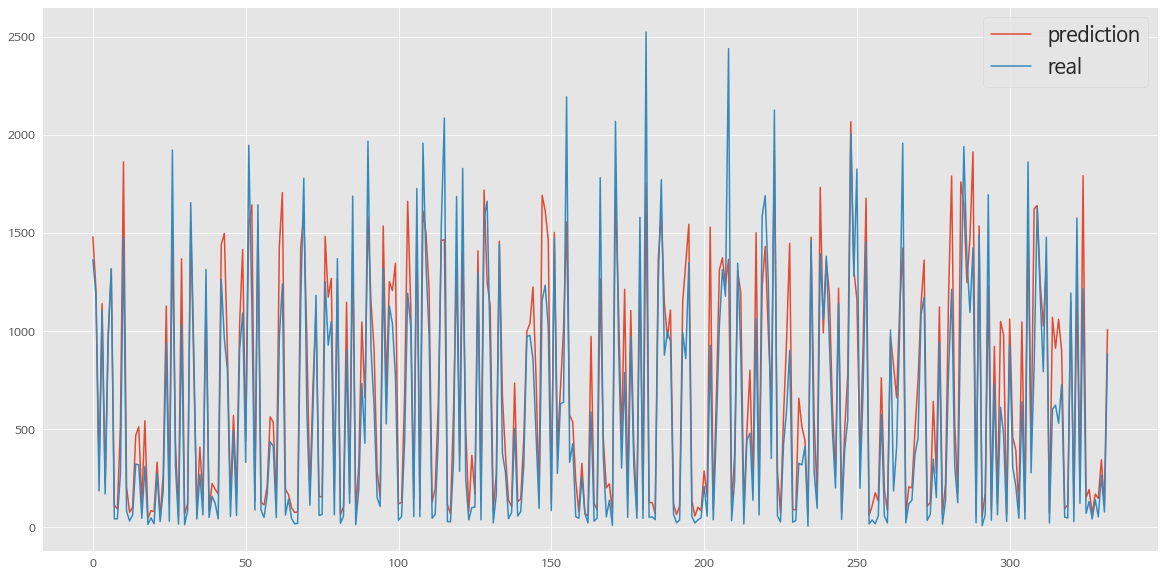

In [233]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(ensemble_pred, label='prediction')
plt.plot(val_y, label='real')
plt.legend(fontsize=20)
plt.show()

In [232]:
from sklearn.metrics import accuracy_score

for clf in (gb_reg, xgb, lgbm, cat_reg, voting_reg):
    clf.fit(train_X_prepared, train_y)
    y_pred = clf.predict(val_X_prepared)
    print(clf.__class__.__name__, nmae(val_y, y_pred))

GradientBoostingRegressor 0.2809454327614975
XGBRegressor 0.305092208728757
LGBMRegressor 0.32442512906524673
CatBoostRegressor 0.2868875318413043
VotingRegressor 0.287587983048827


StratifiedKFold로 전체 데이터 학습

In [236]:
X = data.drop('target', axis = 1)
y = data.target
X_prepared = my_pipeline.fit_transform(X)

In [237]:
from sklearn.model_selection import StratifiedKFold

skf_iris = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cnt_iter = 0
accuracy_list = []

for train_idx, test_idx in skf_iris.split(X_prepared, y):
    X_train, X_test = X_prepared[train_idx], X_prepared[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 학습
    voting_reg.fit(X_train, y_train)
    pred = voting_reg.predict(X_test)

    # 정확도 측정
    cnt_iter += 1
    accuracy = nmae(y_test.values, pred)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    print('\n#{0} 교차 검증 정확도 : {1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
          .format(cnt_iter, accuracy, train_size, test_size))
    accuracy_list.append(accuracy)

print("\n## 교차 검증별 정확도: ", np.round(accuracy_list, 4))
print("## 평균 정확도: ", np.mean(accuracy_list))

/home/piai/anaconda3/envs/dacon_1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



#1 교차 검증 정확도 : 0.18406355765583624, 학습 데이터 크기: 886, 검증 데이터 크기: 222

#2 교차 검증 정확도 : 0.20169136718163105, 학습 데이터 크기: 886, 검증 데이터 크기: 222

#3 교차 검증 정확도 : 0.19236464620147264, 학습 데이터 크기: 886, 검증 데이터 크기: 222

#4 교차 검증 정확도 : 0.199369914498508, 학습 데이터 크기: 887, 검증 데이터 크기: 221

#5 교차 검증 정확도 : 0.1991815089989553, 학습 데이터 크기: 887, 검증 데이터 크기: 221

## 교차 검증별 정확도:  [0.1841 0.2017 0.1924 0.1994 0.1992]
## 평균 정확도:  0.19533419890728063


# submission 만들기

In [198]:
data = test.drop('id', axis = 1).copy()
sub_X = data
sub_X_prepared = my_pipeline.fit_transform(sub_X)
y_pred = voting_reg.predict(sub_X_prepared)

In [199]:
submission = pd.read_csv('../data/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [201]:
submission.shape

(1108, 2)

In [167]:
submission['target'] = y_pred
submission.to_csv("../data/submission_baseline4.csv", index=False)